# Currency Predictor

In [102]:
# library import
import requests
import datetime
from io import StringIO

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor

## 1. Data exploration

### Configure currencies and dates to apply prediction

In [103]:
# Enter start & end dates
start_date = datetime.date(2022, 6, 1)
end_date = datetime.date(2022, 12, 1)

# Enter source & target currencies
source_currency = "USD"
target_currency = "INR"

### Gather FX rate data for above params from API and pre-process it

In [111]:
# functions for getting fx data from api
API_URL = "https://marketdata.tradermade.com/api/v1"

def get_api_key():
    return open("api.key", mode='r').read()


def send_api_request(url):
    headers = {'Accept': 'application/json'}
    return requests.get(url=url, headers=headers)


def get_fx_data(source_currency, target_currency, start_date, end_date):
    api_key = get_api_key()
    url = f"{API_URL}/timeseries?currency={source_currency}{target_currency}&api_key={api_key}&start_date={start_date}&end_date={end_date}&format=csv"
    return send_api_request(url).text
 

def get_currency_df(source_currency, target_currency, start_date, end_date):
    currency_rates = get_fx_data(source_currency, target_currency, start_date, end_date)
    return pd.read_csv(StringIO(currency_rates), sep=",")


currency_df = get_currency_df(source_currency, target_currency, start_date, end_date)
currency_df.head()

,date,open,high,low,close
0,2022-06-01,77.63204,77.95052,77.421,77.57663
1,2022-06-02,77.57663,77.87871,77.360,77.38761
2,2022-06-03,77.38761,77.74010,77.370,77.70285
3,2022-06-06,77.62303,77.90107,77.537,77.84755
4,2022-06-07,77.84753,78.06863,77.608,77.67934


### Explore data, pattern for the provided exchange rate & dates

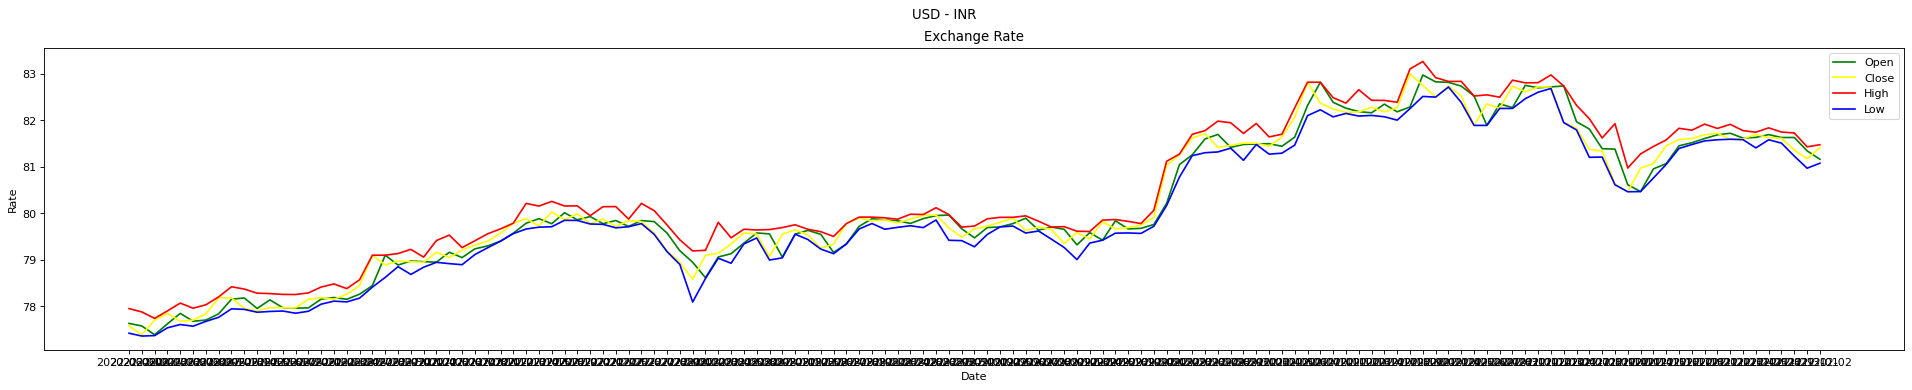

           open      high       low     close
open   1.000000  0.992448  0.993560  0.984996
high   0.992448  1.000000  0.991536  0.991625
low    0.993560  0.991536  1.000000  0.993169
close  0.984996  0.991625  0.993169  1.000000


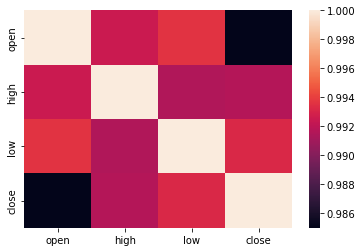

In [112]:
plt.figure(figsize=(30,5), dpi=80)
plt.suptitle(f"{source_currency} - {target_currency}")
plt.title(f"Exchange Rate")
plt.plot(currency_df['date'], currency_df['open'], color='green', label='Open')
plt.plot(currency_df['date'], currency_df['close'], color='yellow', label='Close')
plt.plot(currency_df['date'], currency_df['high'], color='red', label='High')
plt.plot(currency_df['date'], currency_df['low'], color='blue', label='Low')
plt.legend()
plt.xlabel("Date")
plt.ylabel("Rate")
plt.show()

print(currency_df.corr())
sns.heatmap(currency_df.corr())
plt.show()

In [114]:
x = currency_df[["open", "high", "low"]].to_numpy()
y = currency_df["close"].to_numpy().reshape(-1, 1)

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=42)

## Data Analysis

### Applying Decision Tree Regressor model

In [115]:
dtr_model = DecisionTreeRegressor()
dtr_model.fit(xtrain, ytrain)
dtr_y_pred = dtr_model.predict(xtest)

pred_data_decision_tree = pd.DataFrame(data={"Predicted Rate": dtr_y_pred.flatten()})
print("Score of the Decision Tree Regressor Model: ", dtr_model.score(xtest, ytest)*100)

Score of the Decision Tree Regressor Model:  96.44202477358597


#### Plotting prediction results with actual results

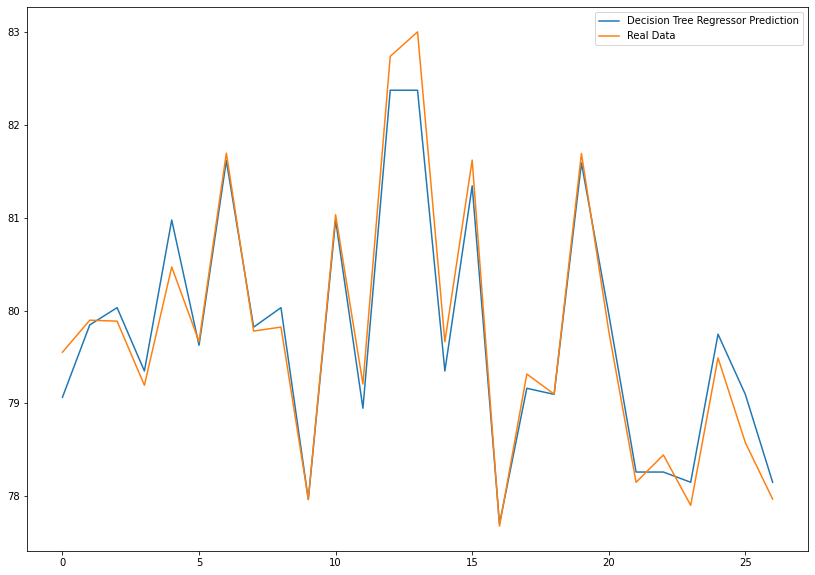

In [117]:
plt.figure(figsize=(14, 10))
plt.plot(dtr_y_pred, label = "Decision Tree Regressor Prediction")
plt.plot(ytest, label = "Real Data")
plt.legend()
plt.show()

### Applying Multilayer Perceptron (MLP)

In [118]:
mlp_model = MLPRegressor(activation='relu', max_iter = 4000, alpha = 100, hidden_layer_sizes=50, random_state=3, 
                   learning_rate_init=0.001, learning_rate='adaptive')

mlp_model.fit(xtrain, ytrain.flatten())
mlp_y_pred = mlp_model.predict(xtest)
print("Score of the MLP Model: ", mlp_model.score(xtest, ytest) * 100)

Score of the MLP Model:  95.37709237664261


#### Plotting prediction results with actual results

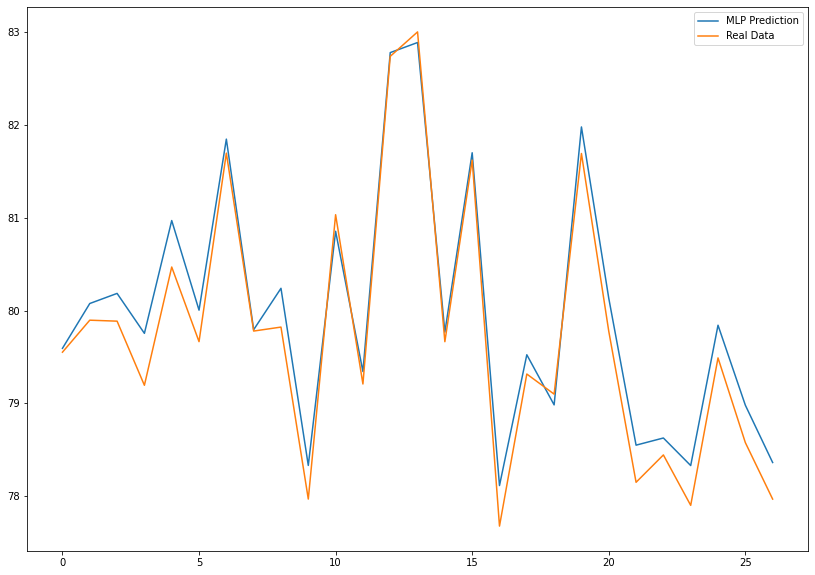

In [119]:
plt.figure(figsize=(14, 10))
plt.plot(mlp_y_pred, label = "MLP Prediction")
plt.plot(ytest, label = "Real Data")
plt.legend()
plt.show()

## Data evaluation

## Outcome/conclusion